In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn import metrics 
import shap

In [39]:
def get_model_performance(file_path, data, training_data, validation_data, y_train, y_validate):
    loaded_model = xgb.Booster()
    loaded_model.load_model(file_path)

    validation_probabilities = loaded_model.predict(validation_data)
    validation_predictions = np.argmax(validation_probabilities, axis=1)
    validation_counts = np.bincount(validation_predictions)
    validation_accuracy = metrics.accuracy_score(validation_predictions, y_validate)
    print(f'Validation data has {(np.sum(y_validate == 0, axis=0).values[0])} completions, {(np.sum(y_validate == 2, axis=0).values[0])} incompletions and {(np.sum(y_validate == 1, axis=0).values[0])} breakups')
    print(f'Predicted {validation_counts[0]} completions, {validation_counts[2]} incompletions, and {validation_counts[1]} breakups, Accuracy: {np.round(validation_accuracy, 5)}')
    
    incompletion_predictions = [1 if x == 2 else x for x in validation_predictions]
    validation_incompletions = [1 if x == 2 else x for x in y_validate.outcome]
    validation_incompletion_accuracy = metrics.accuracy_score(incompletion_predictions, validation_incompletions)
    print(f'Prediction incompletion accuracy {np.round(validation_incompletion_accuracy, 5)}')

    incompletion_probability = 1 - data['cp']
    incompletion_probability = incompletion_probability[2449:3033]
    predicted_incompletion_probability = 1 - validation_probabilities[:, 0]
    incompletion_rmse = np.sqrt(np.mean((incompletion_probability - predicted_incompletion_probability)**2))
    print(f'Validation Incompletion Rate RMSE {np.round(incompletion_rmse, 5)}')

    validation_roc = metrics.roc_auc_score(y_validate, validation_probabilities, average='weighted', multi_class='ovr')
    print(f'ROC on validation: {np.round(validation_roc, 5)}')

    SHAP = loaded_model.predict(training_data, pred_interactions=True)
    xgb.plot_importance(loaded_model)

In [22]:
params = {
    'objective': 'multi:softprob',
    'num_class' : 3,
    'max_depth' : 10,
    'eta' : 0.5,
    'subsample' : 1,
    'max_delta_step' : 10,
    'alpha' : 10,
    'seed' : 11052025
}

default_params = {
    'objective': 'multi:softprob',
    'num_class' : 3,
    'seed' : 11062025
}

In [3]:
data = pd.read_csv('Data/processed/data_for_model.csv')
pbp_data = pd.read_parquet('Data/play_by_play_2023.parquet')
pbp_data = pbp_data[['play_id', 'old_game_id', 'cp']]
pbp_data['play_id'] = pbp_data['play_id'].astype(int)
pbp_data['game_id'] = pbp_data['old_game_id'].astype(int)
supplementary_data = pd.read_csv('Data/supplementary_data.csv')
data = data.merge(pbp_data, on = ['game_id', 'play_id'], how = 'inner')

C:\Users\jerem\AppData\Local\Temp\ipykernel_26480\3733051014.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supplementary_data = pd.read_csv('Data/supplementary_data.csv')


In [4]:
for col in data.select_dtypes(include=['int64']).columns:
    data[col] = data[col].astype(int)
for col in data.select_dtypes(include=['float64']).columns:
    data[col] = data[col].astype(float)
data['player_height'] = data['player_height'].apply(lambda x: int(x.split('-')[0])*12 + int(x.split('-')[1]))
data['seconds_left'] = data['game_clock'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
extra_seconds = {1: 60*15*3, 2: 60*15*2, 3: 60*15, 4: 0}
data['seconds_left'] = data['seconds_left'] + data['quarter'].map(extra_seconds)
data['player_position'] = data['player_position'].astype('category')
data['play_action'] = data['play_action'].astype('category')
data['dropback_type'] = data['dropback_type'].astype('category')
data['team_coverage_type'] = data['team_coverage_type'].astype('category')
data['route_of_targeted_receiver'] = data['route_of_targeted_receiver'].astype('category')
data['qb_hit'] = data['qb_hit'].astype('category')
data['down'] = data['down'].astype('category')
data['outcome'] = data['outcome'].astype('category')

In [7]:
X = data.drop(['game_id', 'play_id', 'player_name', 'disruption', 'pd', 'int', 'quarter', 'game_clock',
               'pass_result', 'outcome', 'old_game_id', 'cp'], axis = 1)

enc = LabelEncoder()
y = data[['outcome', 'week']].copy()
y['outcome'] = enc.fit_transform(y['outcome']) #0 = complete, 1 = disruption, 2 = incomplete

In [8]:
X_train = X[X['week'] <= 12].drop(['week'], axis = 1)
X_validate = X[(X['week'] <= 15) & (X['week'] > 12)].drop(['week'], axis = 1)
X_test = X[X['week'] > 15].drop(['week'], axis = 1)

y_train = y[y['week'] <= 12].drop(['week'], axis = 1)
y_validate = y[(y['week'] <= 15) & (X['week'] > 12)].drop(['week'], axis = 1)
y_test = y[y['week'] > 15].drop(['week'], axis = 1)

# API Fit

In [9]:
enc = LabelEncoder()
y = data[['outcome', 'week']].copy()
y['outcome'] = enc.fit_transform(y['outcome'])

y['outcome'] = enc.fit_transform(y['outcome'])

Xy_train = xgb.DMatrix(X_train, y_train, enable_categorical = True)
Xy_validate = xgb.DMatrix(X_validate, y_validate, enable_categorical = True)
Xy_test = xgb.DMatrix(X_test, y_test, enable_categorical = True)

In [23]:
booster = xgb.train(default_params, Xy_train)
# Must use JSON for serialization, otherwise the information is lost
booster.save_model("test_categorical_model.json")

# API without game dependent features

In [29]:
# remove down, yards to go, seconds_left, defensive_point_diff
enc = LabelEncoder()
y = data[['outcome', 'week']].copy()
y['outcome'] = enc.fit_transform(y['outcome'])

X_no_game = X.drop(['down', 'yards_to_go', 'seconds_left', 'defensive_point_diff'], axis = 1)
X_train_no_game = X_no_game[X_no_game['week'] <= 12].drop(['week'], axis = 1)
y_train = y[y['week'] <= 12].drop(['week'], axis = 1)
X_validate_no_game = X_no_game[(X_no_game['week'] <= 15) & (X_no_game['week'] > 12)].drop(['week'], axis = 1)

Xy_train_no_game = xgb.DMatrix(X_train_no_game, y_train, enable_categorical = True)
Xy_validate_no_game = xgb.DMatrix(X_validate_no_game, y_validate, enable_categorical = True)

In [30]:
booster = xgb.train(default_params, Xy_train_no_game)
# Must use JSON for serialization, otherwise the information is lost
booster.save_model("test_model_no_game_params.json")

# Train with past 1 second

In [35]:
last_ten_frames = pd.read_csv('Data/processed/last_ten_frames_of_input.csv')
X_last_second = data.merge(last_ten_frames, on = ['game_id', 'play_id', 'player_name'], how = 'inner')
X_last_second = X_last_second.drop(['game_id', 'play_id', 'player_name', 'disruption', 'pd', 'int', 'quarter', 'game_clock',
               'pass_result', 'outcome', 'old_game_id', 'cp', 'down', 'yards_to_go', 'seconds_left', 'player_role'], axis = 1)

X_train_last_second = X_last_second[X_last_second['week'] <= 12].drop(['week'], axis = 1)
X_validate_last_second= X_last_second[(X_last_second['week'] <= 15) & (X_last_second['week'] > 12)].drop(['week'], axis = 1)

Xy_train_last_second = xgb.DMatrix(X_train_last_second, y_train, enable_categorical = True)
Xy_validate_last_second = xgb.DMatrix(X_validate_last_second, y_validate, enable_categorical = True)

In [36]:
booster = xgb.train(default_params, Xy_train_last_second)
# Must use JSON for serialization, otherwise the information is lost
booster.save_model("test_model_last_second.json")

# Train with past half second

In [41]:
cols_to_drop = [col for col in X_last_second.columns if col.endswith(('six', 'seven', 'eight', 'nine', 'ten'))]
X_half_second = X_last_second.drop(columns=cols_to_drop)
X_train_half_second = X_half_second[X_half_second['week'] <= 12].drop(['week'], axis = 1)
X_validate_half_second= X_half_second[(X_half_second['week'] <= 15) & (X_half_second['week'] > 12)].drop(['week'], axis = 1)

Xy_train_half_second = xgb.DMatrix(X_train_half_second, y_train, enable_categorical = True)
Xy_validate_half_second = xgb.DMatrix(X_validate_half_second, y_validate, enable_categorical = True)

In [42]:
booster = xgb.train(default_params, Xy_train_half_second)
# Must use JSON for serialization, otherwise the information is lost
booster.save_model("test_model_half_second.json")

# Evaluate models

Validation data has 375 completions, 184 incompletions and 25 breakups
Predicted 479 completions, 99 incompletions, and 6 breakups, Accuracy: 0.64384
Prediction incompletion rate 0.65411
Validation Incompletion Rate RMSE 0.15367
ROC on validation: 0.61243


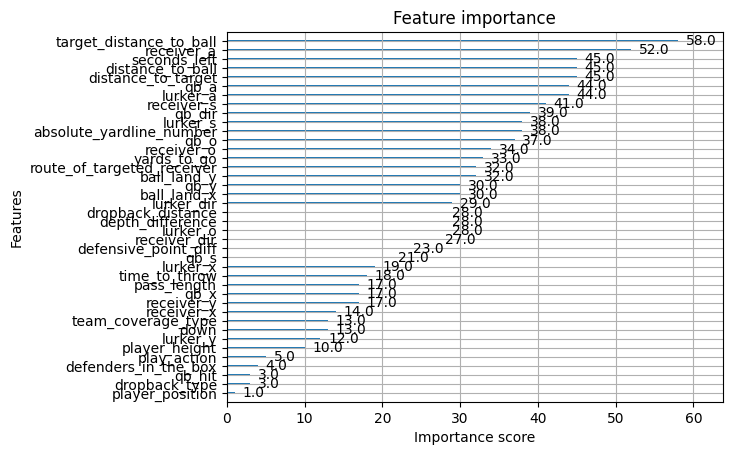

In [25]:
get_model_performance('test_categorical_model.json', data, Xy_train, Xy_validate, y_train, y_validate)

Validation data has 375 completions, 184 incompletions and 25 breakups
Predicted 491 completions, 87 incompletions, and 6 breakups, Accuracy: 0.64726
Prediction incompletion rate 0.65411
Validation Incompletion Rate RMSE 0.15199
ROC on validation: 0.61654


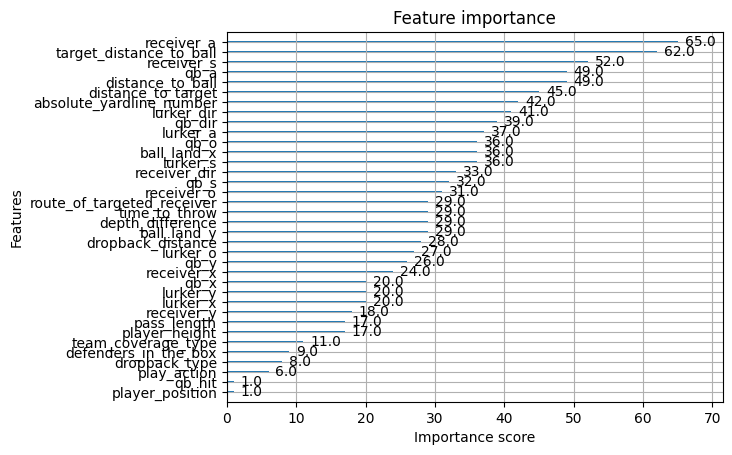

In [31]:
get_model_performance('test_model_no_game_params.json', data, Xy_train_no_game, Xy_validate_no_game, y_train, y_validate)

Validation data has 375 completions, 184 incompletions and 25 breakups
Predicted 491 completions, 86 incompletions, and 7 breakups, Accuracy: 0.66096
Prediction incompletion rate 0.67123
Validation Incompletion Rate RMSE 0.15384
ROC on validation: 0.6265


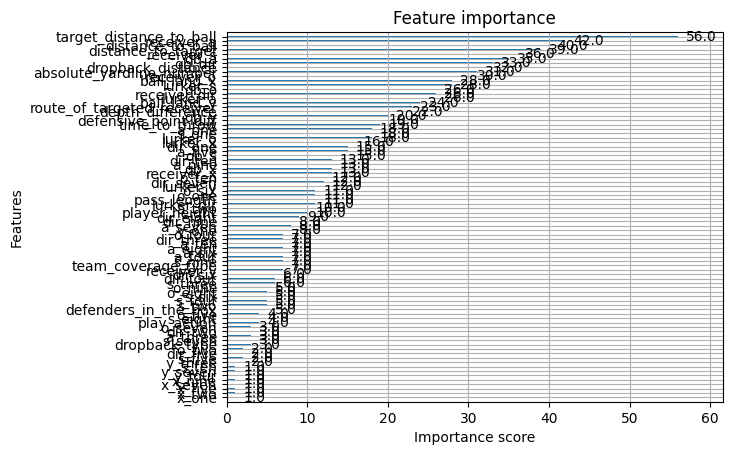

In [38]:
get_model_performance('test_model_last_second.json', data, Xy_train_last_second, Xy_validate_last_second, y_train, y_validate)

Validation data has 375 completions, 184 incompletions and 25 breakups
Predicted 496 completions, 86 incompletions, and 2 breakups, Accuracy: 0.64555
Prediction incompletion accuracy 0.65582
Validation Incompletion Rate RMSE 0.14227
ROC on validation: 0.61078


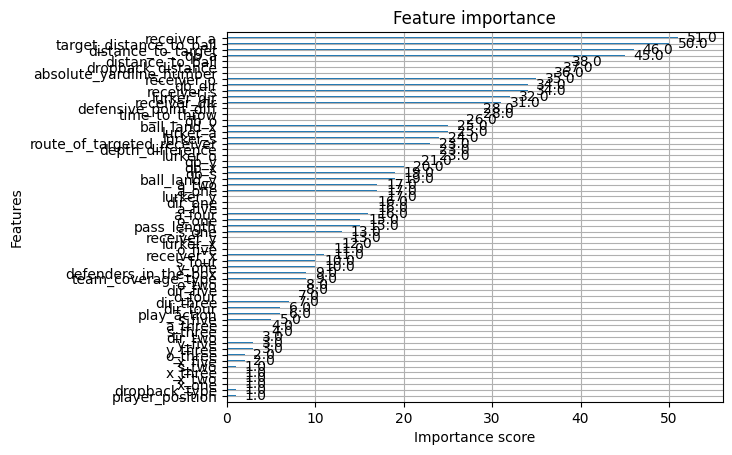

In [43]:
get_model_performance('test_model_half_second.json', data, Xy_train_half_second, Xy_validate_half_second, y_train, y_validate)